In [1]:
#imports
import pandas as pd
import numpy as np
import pathlib

import sklearn.preprocessing as preprocessing
from sklearn import linear_model
from sklearn import metrics, model_selection
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable



import seaborn as sns; sns.set_theme(style='ticks', context='talk')
import colorcet as cc


In [8]:
#number of samples per reactor
no_samples = 86
#time between sample collection (seconds)
sample_time_sec = 270
#length of sin wave (minutes)
period = 25
#length of sin wave (seconds)
period_s = 25*60
#duration of total experiment (seconds)
duration = no_samples * sample_time_sec
#experiment name
experiment = '250127AKDER003'
#list of bad data
bad_data = None

In [9]:
#define sin wave task (note: time here is in seconds and allows changes every 15 s)
def sine_wave(min_per_period, duration, time_per_cond_change = 15, amplitude = 0.5, phase = 0):
    #create empty dataframe
    df = pd.DataFrame()
    # Generate time values
    t_change = np.linspace(0, duration, int(duration/time_per_cond_change), endpoint=False)
    # Compute sine wave values
    y_change = amplitude * np.sin(2 * np.pi * t_change/min_per_period + phase) + 0.5
    #assign time and y values in dataframe
    df['time (s)'] = t_change
    df['y value'] = y_change
    #reindex to time column 
    df = df.set_index('time (s)')
    return  df

#create df of conc change timepoints and corresponding concentrations
sin_df = sine_wave(period_s, duration = duration)

In [5]:
data_df = pd.read_csv("../data/RC_dynamic.csv", index_col=0)

data_df

,Sample,time (s),y value,1021,1043p4,1043p5,1054,1179,1201,259,...,912,923,928,950,960,961,972,980,994,999
0,1_01,0.0,0.500000,0.001464,0.001252,0.001373,0.001465,0.000235,0.000187,0.000126,...,0.002097,0.001742,0.000808,0.001995,0.000277,0.001052,0.003724,0.000054,0.002869,0.000269
1,1_02,270.0,0.952414,0.001464,0.001325,0.001653,0.001750,0.000336,0.000142,0.000064,...,0.002432,0.002186,0.000821,0.002256,0.000296,0.001171,0.004402,0.000048,0.003747,0.000291
2,1_03,540.0,0.885257,0.001519,0.001472,0.001641,0.001793,0.000382,0.000185,0.000060,...,0.002518,0.002224,0.000835,0.002172,0.000398,0.001119,0.004406,0.000083,0.003796,0.000294
3,1_04,810.0,0.375655,0.001829,0.001750,0.001517,0.001557,0.000531,0.000308,0.000045,...,0.002268,0.001904,0.000757,0.002045,0.000504,0.001068,0.003890,0.000090,0.003365,0.000364
4,1_05,1080.0,0.008856,0.002106,0.001854,0.001491,0.001613,0.000625,0.000430,0.000064,...,0.002286,0.002037,0.000822,0.002110,0.000622,0.001172,0.004058,0.000068,0.003500,0.000454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1_82,21870.0,0.259123,0.001715,0.001602,0.001635,0.001731,0.000524,0.000216,0.000053,...,0.002614,0.002098,0.000795,0.002144,0.000488,0.001178,0.004271,0.000102,0.003680,0.000298
82,1_83,22140.0,0.000987,0.001646,0.001554,0.001306,0.001450,0.000475,0.000309,0.000065,...,0.002051,0.001753,0.000730,0.001805,0.000504,0.000937,0.003526,0.000106,0.002986,0.000289
83,1_84,22410.0,0.315938,0.000787,0.000673,0.001448,0.001694,0.000189,0.000133,0.000064,...,0.002544,0.002136,0.000800,0.002152,0.000197,0.001135,0.004192,0.000045,0.003432,0.000176
84,1_85,22680.0,0.842274,0.000806,0.000662,0.001664,0.001804,0.000125,0.000054,0.000061,...,0.002805,0.002314,0.000891,0.002395,0.000108,0.001296,0.004696,0.000021,0.003770,0.000170


   Sample  time (s)   y value      1021    1043p4    1043p5      1054  \
0    1_01       0.0  0.500000  0.001464  0.001252  0.001373  0.001465   
1    1_02     270.0  0.952414  0.001464  0.001325  0.001653  0.001750   
2    1_03     540.0  0.885257  0.001519  0.001472  0.001641  0.001793   
3    1_04     810.0  0.375655  0.001829  0.001750  0.001517  0.001557   
4    1_05    1080.0  0.008856  0.002106  0.001854  0.001491  0.001613   
..    ...       ...       ...       ...       ...       ...       ...   
81   1_82   21870.0  0.259123  0.001715  0.001602  0.001635  0.001731   
82   1_83   22140.0  0.000987  0.001646  0.001554  0.001306  0.001450   
83   1_84   22410.0  0.315938  0.000787  0.000673  0.001448  0.001694   
84   1_85   22680.0  0.842274  0.000806  0.000662  0.001664  0.001804   
85   1_86   22950.0  0.975528  0.000913  0.000664  0.001637  0.001778   

        1179      1201       259  ...       960       961       972       980  \
0   0.000235  0.000187  0.000126  ...  0.0

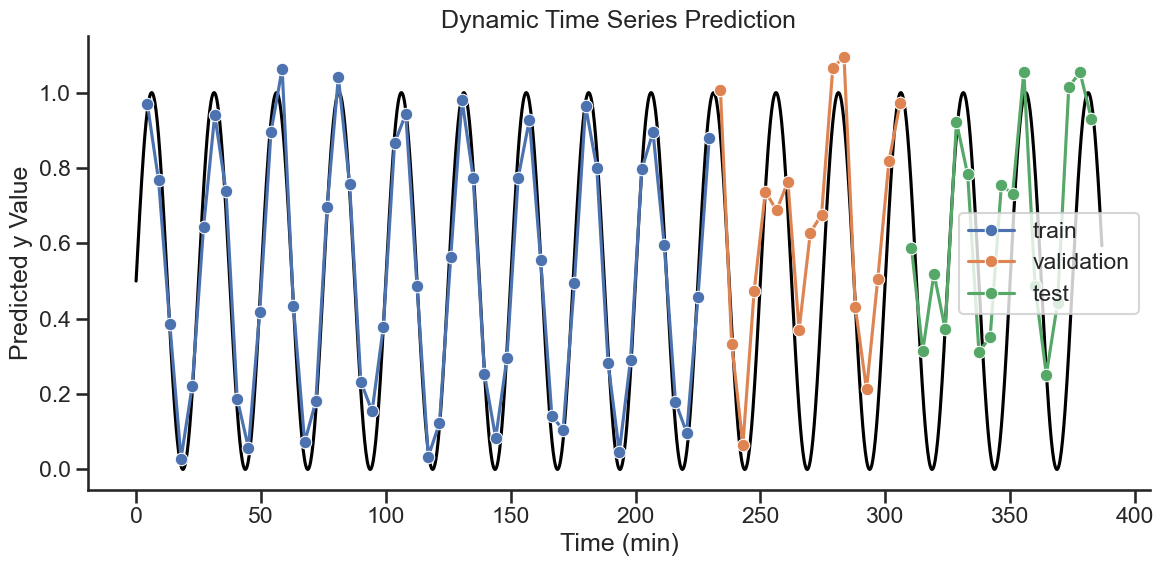

                   0
train       0.002744
validation  0.052219
test        0.100259


In [14]:
def sin_prediction_series(df, alpha_value=2, predict_ahead=1):

    #define how far ahead to predict
    shift_value = -predict_ahead
    #define model
    reg = linear_model.Ridge(alpha=alpha_value)
    #create empty dict to store score
    mse = {}
    #create empty dict to store predictions
    prediction_df = pd.DataFrame()

    #define parameter columns
    para_columns = ['time (s)', 'y value', 'Sample']
    #define feature columns
    feature_columns = [col for col in df.columns if col not in para_columns]

    #shift y value ahead to create target column
    df['value to predict'] = df['y value'].shift(shift_value)
    #shift time ahead to align with target column
    df['predict time (min)'] = df['time (s)'].shift(shift_value) / 60

    #drop bad data
    df_nona = df.dropna().copy()
    
    #define inputs and features
    U = df_nona['predict time (min)'].values
    X = df_nona.drop(columns=['time (s)', 'y value', 'Sample',
                                    'value to predict', 'predict time (min)']).values
    
    #scale inputs
    X = preprocessing.StandardScaler().fit_transform(X)

    #define target values
    y_index = df_nona['value to predict'].values

    #first split to train vs val/test
    U_train, U_val_test, X_train, X_val_test, y_train, y_val_test = train_test_split(
        U, X, y_index, train_size=0.6, shuffle=False)
    
    #then split val and test
    U_validation, U_test, X_validation, X_test, y_validation, y_test = train_test_split(
        U_val_test, X_val_test, y_val_test, train_size=0.5, shuffle=False)

    #train model
    reg.fit(X_train, y_train)

    #use model to predict for training, validation and test sets
    y_train_pred = pd.DataFrame(reg.predict(X_train), columns=['predicted y values'])
    y_validation_pred = pd.DataFrame(reg.predict(X_validation), columns=['predicted y values'])
    y_test_pred = pd.DataFrame(reg.predict(X_test), columns=['predicted y values'])


    # Add metadata to predictions
    y_train_pred['predict time (min)'] = U_train
    y_train_pred['dataset'] = 'train'

    y_validation_pred['predict time (min)'] = U_validation
    y_validation_pred['dataset'] = 'validation'

    y_test_pred['predict time (min)'] = U_test
    y_test_pred['dataset'] = 'test'

    # MSE Calculations
    mse['train'] = metrics.mean_squared_error(y_train_pred['predicted y values'].values, y_train)
    mse['validation'] = metrics.mean_squared_error(y_validation_pred['predicted y values'].values, y_validation)
    mse['test'] = metrics.mean_squared_error(y_test_pred['predicted y values'].values, y_test)

    # Combine predictions into one df
    prediction_df = pd.concat([y_train_pred, y_validation_pred, y_test_pred], axis=0)
    prediction_df_copy = prediction_df.set_index('predict time (min)', drop = True)

    #add back into df containing all data
    merged_df = df.join(prediction_df_copy, on='predict time (min)')

    #store mse in a df
    mse_df = pd.DataFrame(mse, index = [0])
    mse_df_T = mse_df.T

    return merged_df, mse_df_T

def plot_predictions(df, title, string = None):
    
    plt.figure(figsize=(12, 6))

    sns.lineplot(data = df, x = 'predict time (min)', 
                y = 'predicted y values', marker = 'o', hue = 'dataset', linestyle = '-', zorder = 1)
    
    plt.xlabel('Time (min)')
    plt.ylabel('Predicted y Value')
    sin_df['time (min)'] = sin_df.index/60
    sns.lineplot(sin_df, x = 'time (min)', y = 'y value', color = 'black', zorder = 0)
    plt.title(title)
    #plt.legend()
    sns.despine()
    plt.tight_layout()
    if string != None:
        plt.savefig(string, dpi = 900)
    plt.show()

predictions, score_df = sin_prediction_series(data_df)
print (predictions)
plot_predictions(predictions, string = '../plots/series_predictions_plot.svg', title = 'Dynamic Time Series Prediction')
print (score_df)

alpha value = 0
                       0
train       5.132813e-29
validation  5.323358e-02


/home/mathieu/miniforge3/envs/thesis/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=7.71636e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


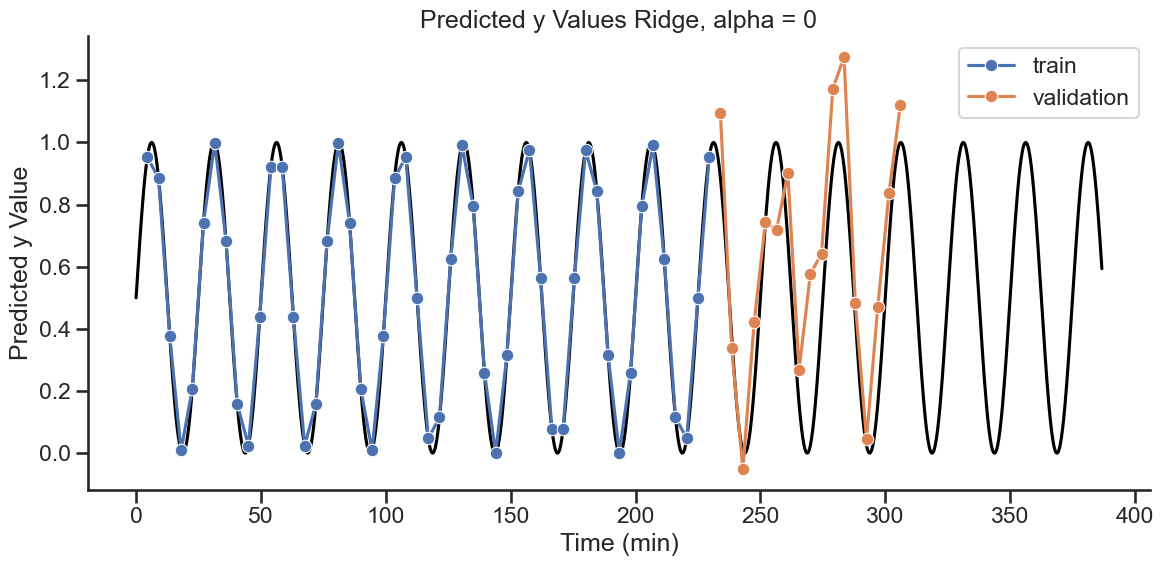

alpha value = 1
                   0
train       0.001191
validation  0.050592


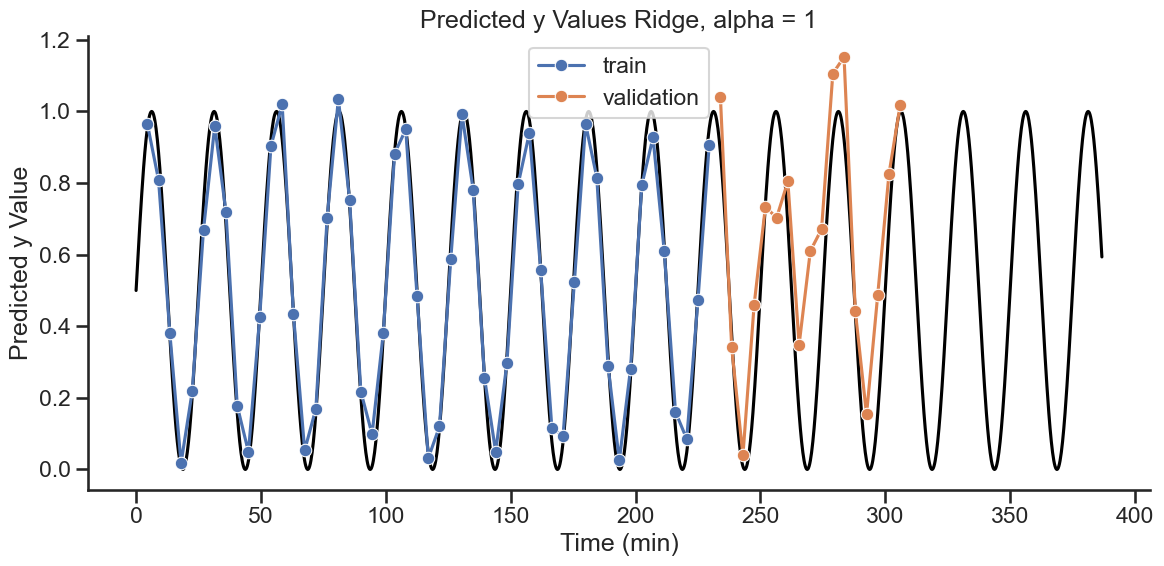

alpha value = 2
                   0
train       0.002744
validation  0.052219


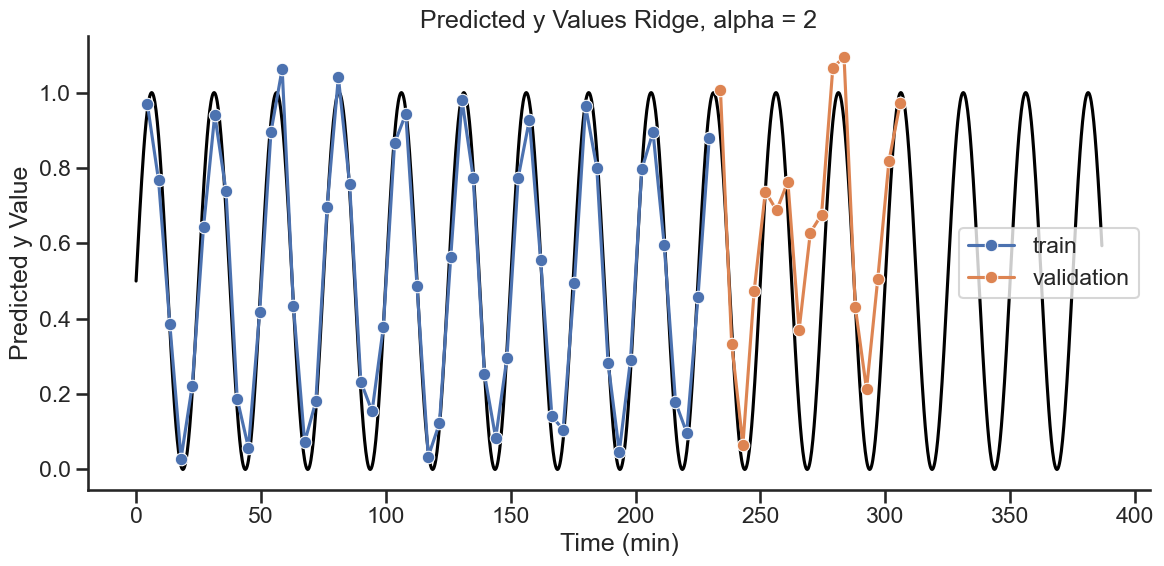

alpha value = 5
                   0
train       0.006745
validation  0.055593


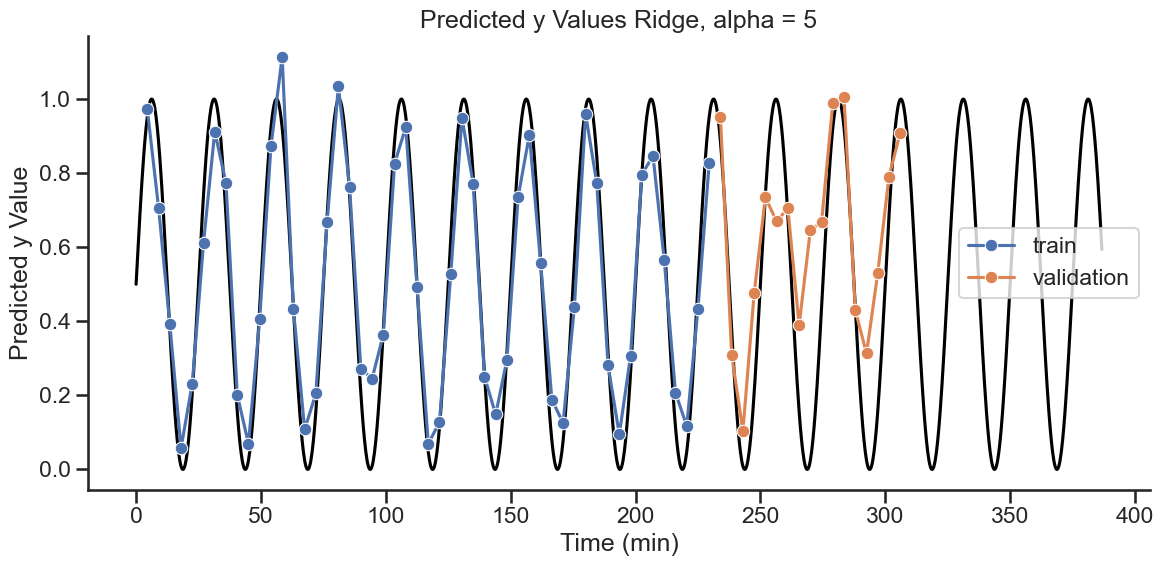

alpha value = 10
                   0
train       0.011712
validation  0.058547


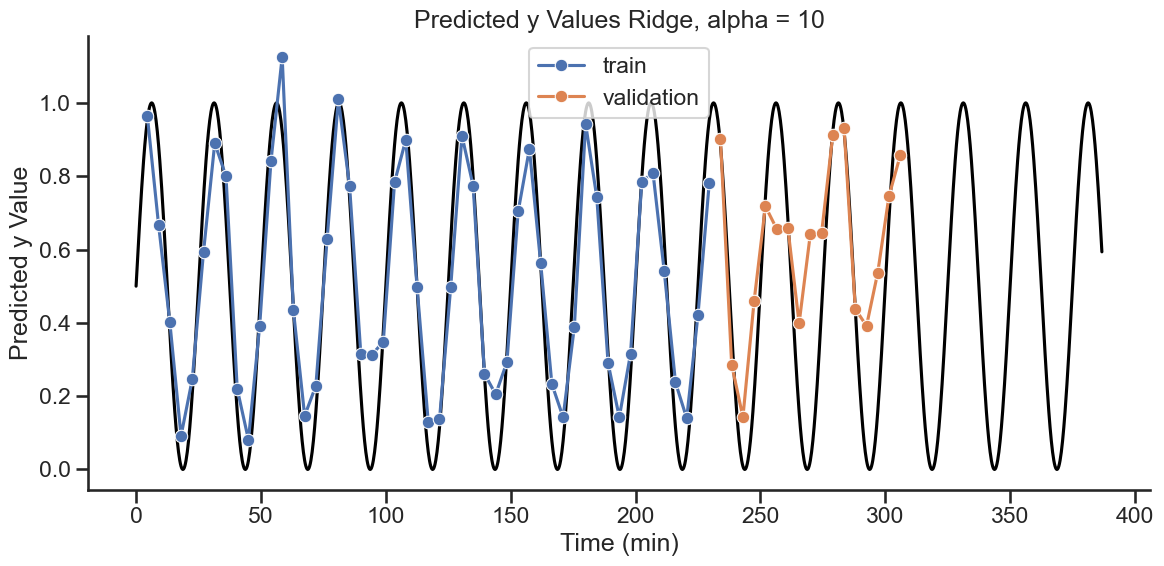

alpha value = 20
                   0
train       0.018955
validation  0.062068


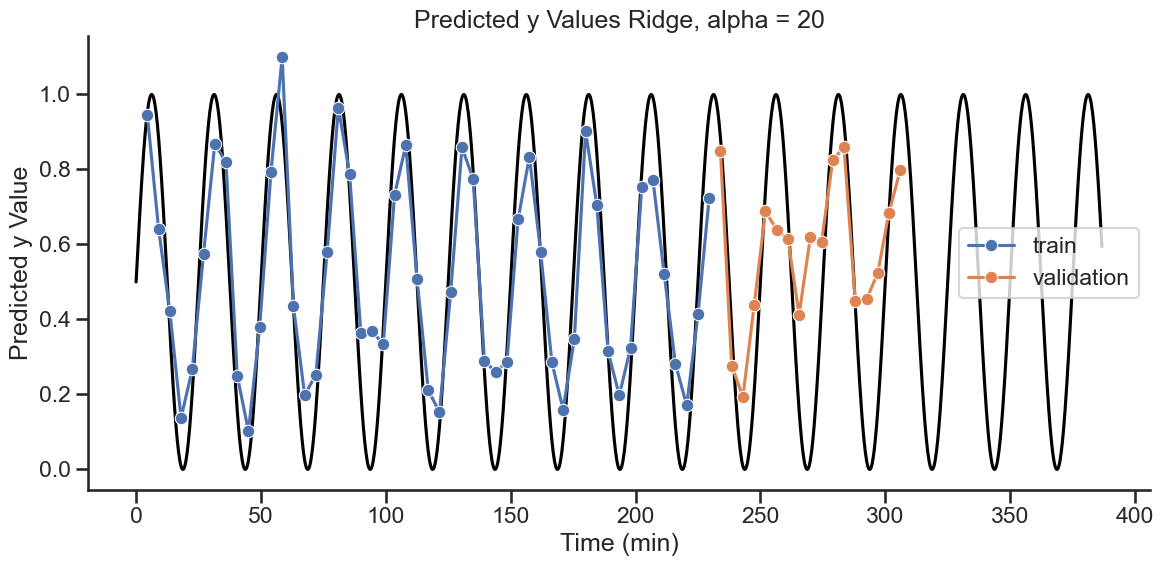

alpha value = 50
                   0
train       0.033656
validation  0.068610


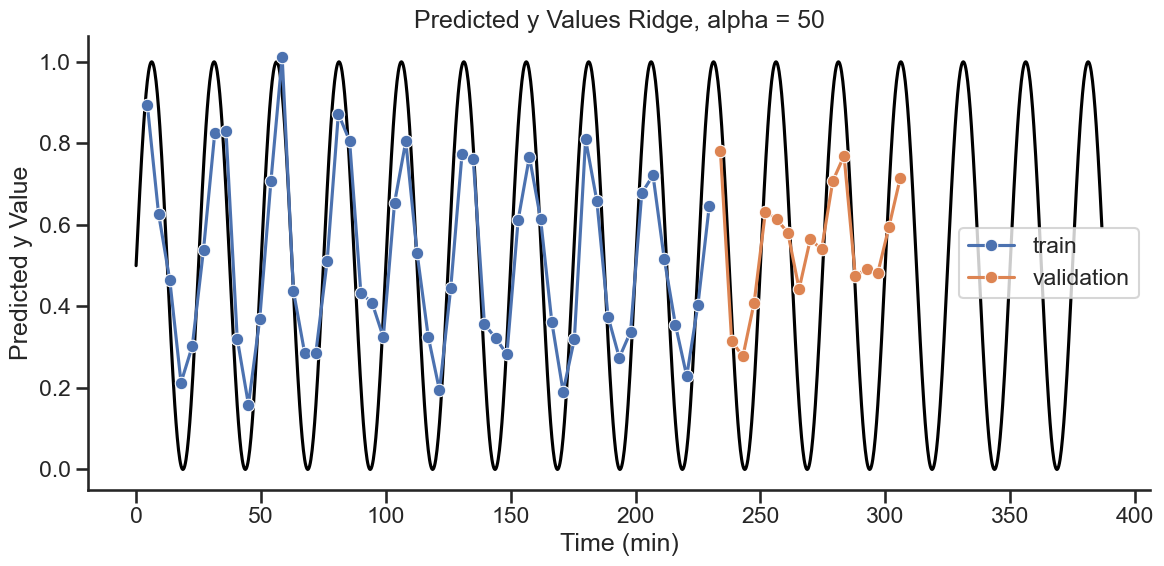

alpha value = 100
                   0
train       0.049063
validation  0.075988


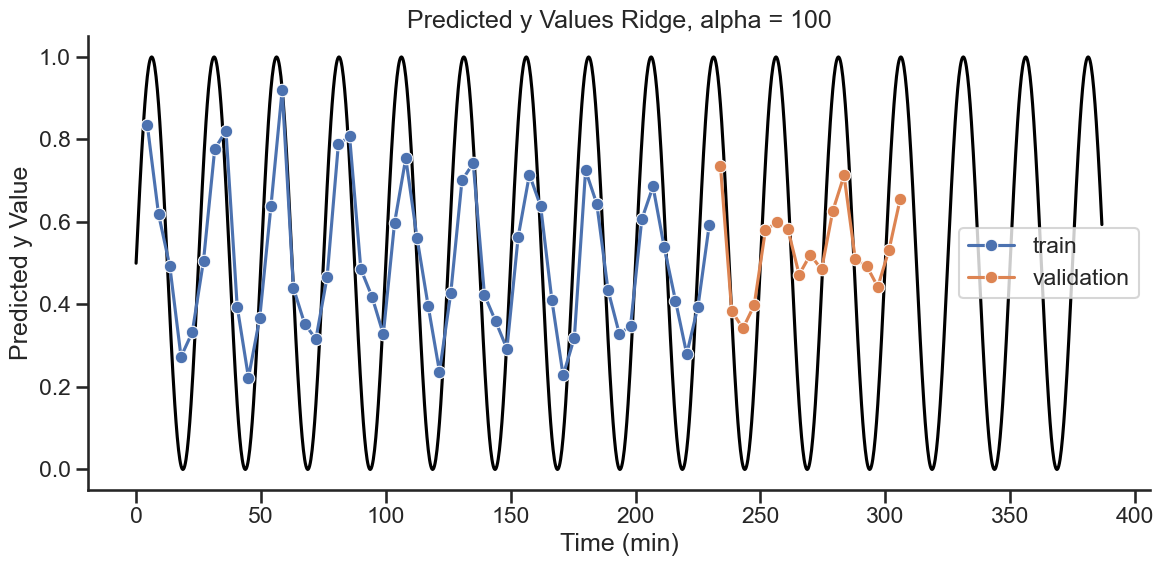

alpha value = 500
                   0
train       0.086514
validation  0.098237


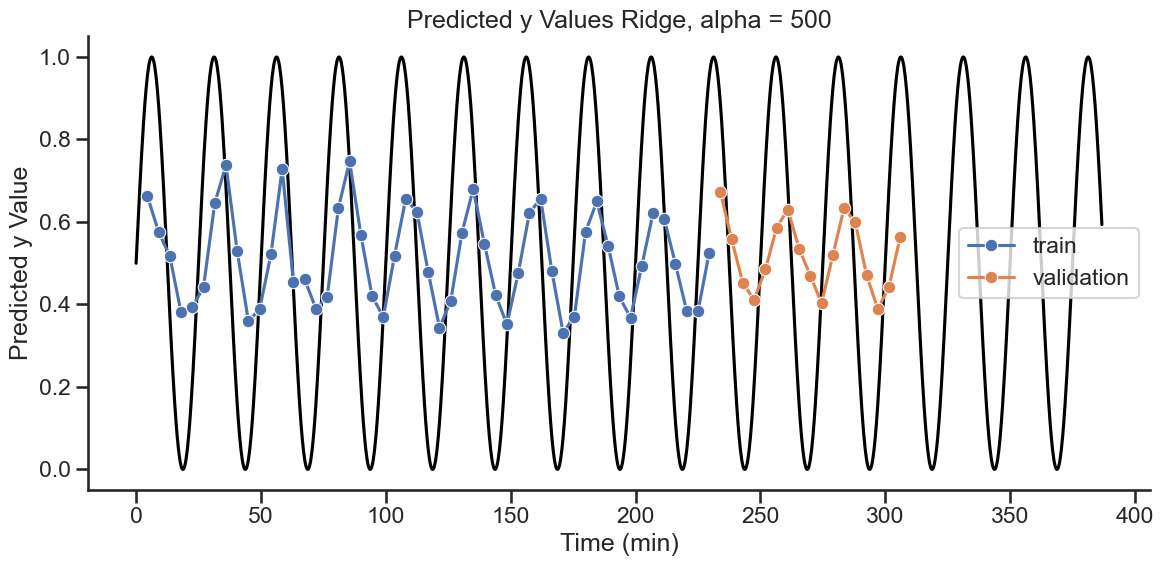

        0         1         2         5         10        20       50   \
0  0.053234  0.050592  0.052219  0.055593  0.058547  0.062068  0.06861   

        100       500  
0  0.075988  0.098237  


In [11]:
#testing alpha values to optimise model parameters

#create list of alpha values to test
alpha_test_values = [0, 1, 2, 5, 10, 20, 50, 100, 500]
#create empty dict to store val scores 
alpha_value_scores = {}

for a in alpha_test_values: 
    print(f'alpha value = {a}')

    #run model and predict
    predictions, score_a_df = sin_prediction_series(data_df, alpha_value= a)
    
    validate_predictions = predictions[predictions['dataset'] == 'validation']
    train_predictions = predictions[predictions['dataset'] == 'train']
    data_to_plot = pd.concat([train_predictions, validate_predictions])
    #print (validate_predictions)
    
    train_val_scores = score_a_df.loc[['train','validation']]
    print (train_val_scores)

    alpha_value_scores[a] = train_val_scores.loc['validation']

    plot_predictions(data_to_plot, title = f'Predicted y Values Ridge, alpha = {a}')

alpha_value_scores_df = pd.DataFrame(alpha_value_scores)
#alpha_value_scores_df.to_csv('reg_strength_var.csv')
print (alpha_value_scores_df)
    

In [ ]:
print (score_df)

score_df.to_csv(f'RC_dynamic_mse_series.csv')

predictions.to_csv(f'RC_dynamic_predicted_values_series.csv')


                   0
train       0.002744
validation  0.052219
test        0.100259


In [ ]:
steps_ahead = [1,2,3,4,5]

steps_df = pd.DataFrame()
step_pred_dict = {}
for step in steps_ahead:
    pred_steps, steps_score = sin_prediction_series(data_df, alpha_value = 2, predict_ahead = step)
    step_pred_dict[f'{step}'] = pred_steps
    #print(step_pred_dict)
    steps_score.reset_index(inplace = True)
    melt_steps_score = steps_score.melt(id_vars= 'index', value_name='score',var_name='reactor')
    #print (melt_steps_score)
    melt_steps_score['steps ahead'] = step

    steps_df = pd.concat([steps_df,melt_steps_score], axis = 0)

#print (steps_df)

test_scores = steps_df.loc[steps_df['index'] =='test']

#print(test_scores.drop('index', axis =1))

test_scores_pivot = test_scores.pivot(columns = ['steps ahead'],values = 'score', index = 'reactor')
test_scores_pivot.to_csv(f'RC_dynamic_test_mse_steps.csv')
print (test_scores_pivot)



steps ahead         1         2         3         4         5
reactor                                                      
0            0.100259  0.068352  0.031246  0.103532  0.034736


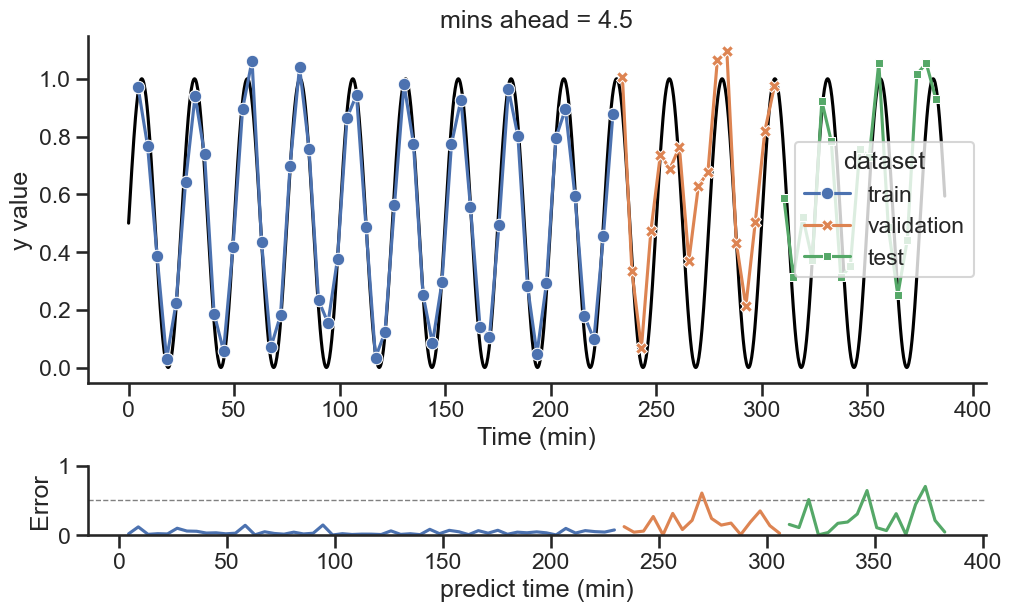

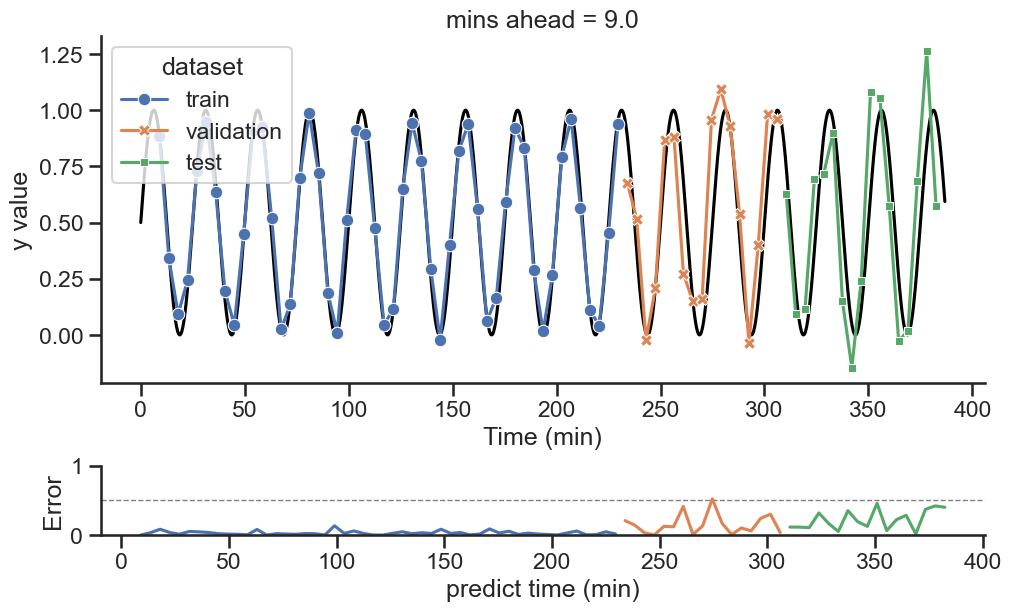

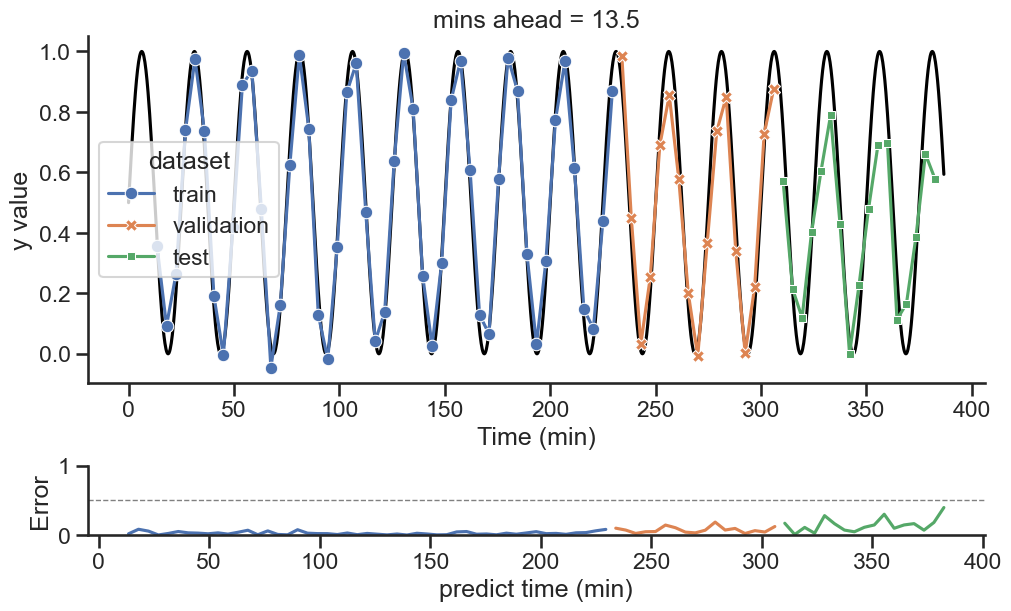

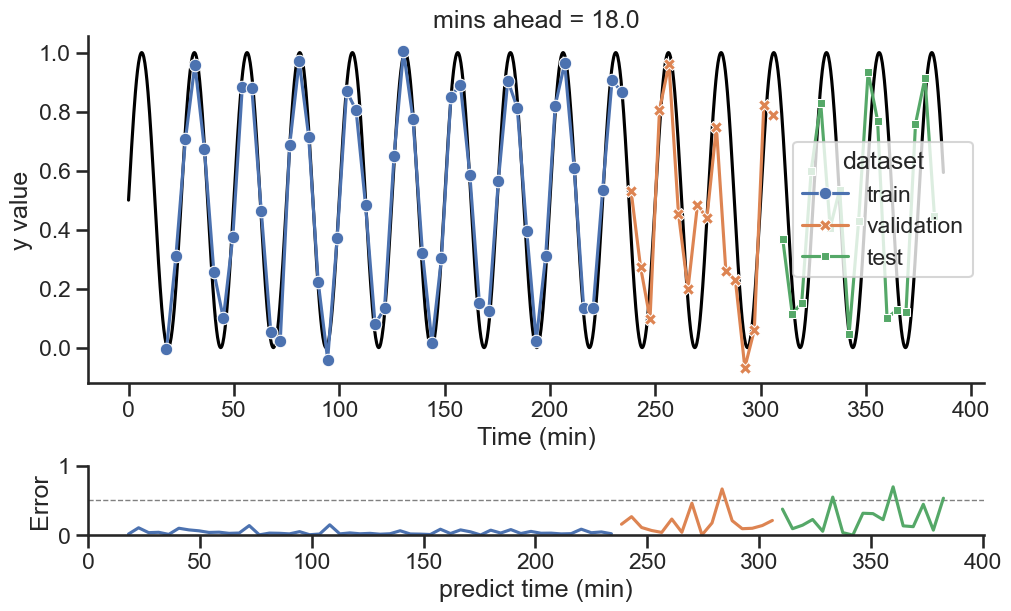

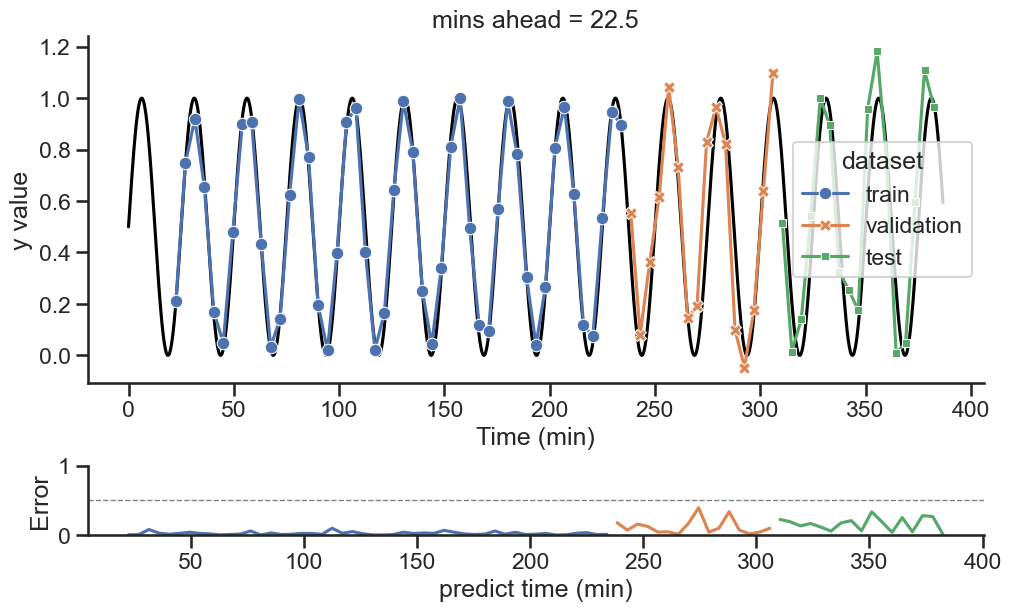

In [16]:

for key, value in step_pred_dict.items():

    #set context 
    sns.set_context('talk')
    #define first figure (sigmoidal plot)
    fig1, axes = plt.subplots(2,1,figsize=(10,6), constrained_layout=True, gridspec_kw={'height_ratios': [5, 1]})
    #sin_end = sin_df.loc[sin_df['time (min)'] >250]
    #plot array against sigmoidal task
    sns.lineplot(sin_df, x = 'time (min)', y = 'y value', color = 'black', ax=axes[0])
    #set title
    axes[0].set_title(f"mins ahead = {int(key)*4.5}")
    #set axes label
    axes[0].set_xlabel(r"Time (min)")
    axes[1].set_ylim(0,1)
    axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    value['difference'] = abs(value['value to predict'] - value['predicted y values'])
    sns.despine()
    sns.lineplot(data = value, x = 'predict time (min)', y = 'predicted y values', hue = 'dataset', style = 'dataset', markers=True, dashes = False,ax=axes[0])
    sns.lineplot(data = value, x = 'predict time (min)', y = 'difference', hue = 'dataset', style = 'dataset', markers=False, dashes = False,ax=axes[1], legend = False)
    axes[1].set_ylabel(r"Error")
    plt.savefig(f"../plots/RC_dynamic_sin_predictions_{key}_step.svg", dpi = 900)
    plt.show()